In [1]:
import geopandas as gpd
import joblib
import numpy as np
import odc.geo.xr  # noqa
from dask import config
#from dask.distributed import Client
from dask.distributed import Client as dask_client
from odc.stac import load
from pystac_client import Client
from shapely import geometry
import depal_fj as dep
from depal_fj import predict_xr
from model import get_overlay
from ipyleaflet import Map, LayersControl, basemaps

In [2]:
%reload_ext autoreload
%autoreload 2

config.set({'distributed.worker.daemon': False})

## Find and load data

Load data and set up your array to use for prediction

In [3]:
# Configure some things up front
chunks = dict(x=2048, y=2048)
year = "2023"
model_file_name = "fj_lulc.model"

aoi = dep.get_island("Viti Levu")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [4]:
catalog = "https://stac.staging.digitalearthpacific.org"
client = Client.open(catalog)

# Search for Sentinel-2 GeoMAD data
items = client.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
    datetime=year
).items()

# Load the data
data = load(items, chunks=chunks, bbox=bbox).squeeze("time")
data

<xarray.Dataset>
Dimensions:      (y: 11207, x: 15526)
Coordinates:
  * y            (y) float64 -1.944e+06 -1.944e+06 ... -2.056e+06 -2.056e+06
  * x            (x) float64 3.033e+06 3.033e+06 ... 3.188e+06 3.188e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/14)
    B02          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    ...           ...
    B12          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    B8A          (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    count        (y, x) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>

In [5]:
loaded_model = joblib.load(model_file_name)

## Run the prediction

In [6]:
filled = data.fillna(-9999.0)

# This runs the actual prediction
with dask_client():
    predicted = predict_xr(loaded_model, filled, proba=True)

    # Convert to int
    cleaned_predictions = predicted.copy(deep=True)
    cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
    cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

    cleaned_predictions = cleaned_predictions.rename(
        {"predictions": "lulc", "probabilities": "prob"}
    ).compute()

cleaned_predictions

predicting...
   probabilities...


<xarray.Dataset>
Dimensions:      (x: 15526, y: 11207)
Coordinates:
  * x            (x) float64 3.033e+06 3.033e+06 ... 3.188e+06 3.188e+06
  * y            (y) float64 -1.944e+06 -1.944e+06 ... -2.056e+06 -2.056e+06
    spatial_ref  int32 3832
Data variables:
    lulc         (y, x) int8 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6
    prob         (y, x) float32 89.57 89.86 89.15 88.5 ... 89.56 88.31 86.85
Attributes:
    grid_mapping:  spatial_ref

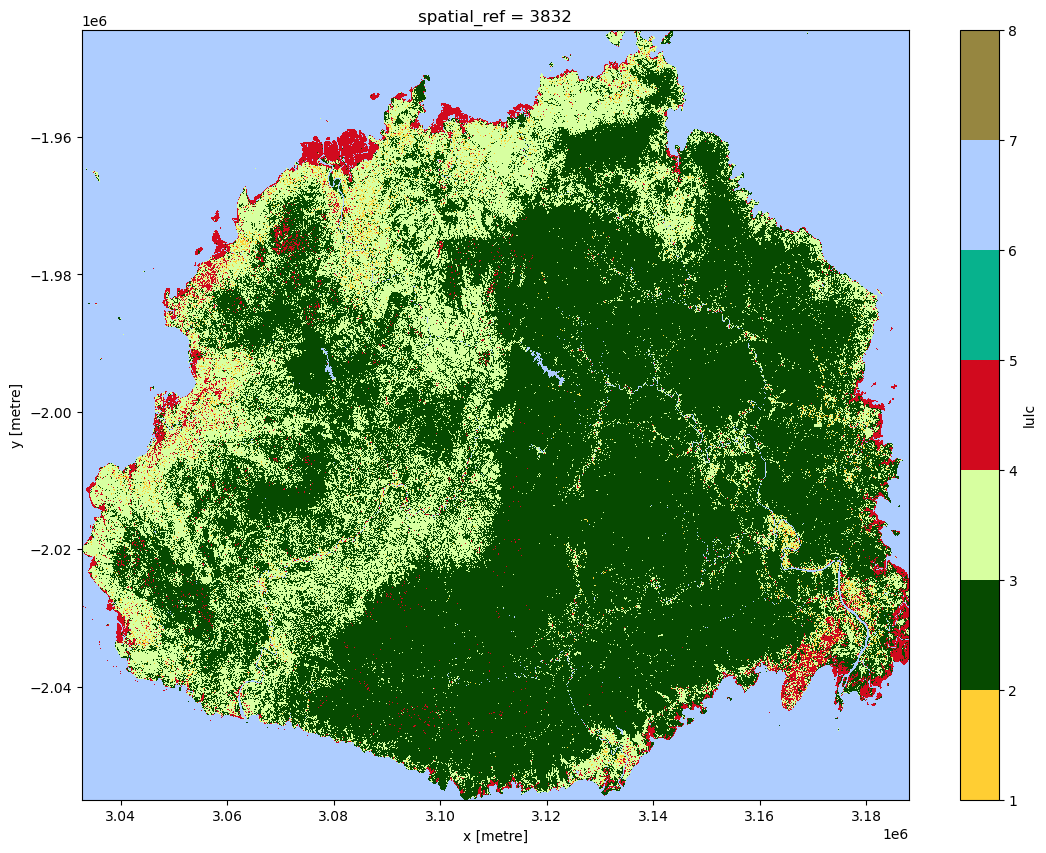

In [10]:
from matplotlib import colors

classes = [
    [1, "Cropland", "#ffce33"],
    [2, "Forest", "#064a00"],
    [3, "Grassland", "#d7ffa0"],
    [4, "Settlement", "#d10a1e"],
    [5, "Mangroves", "#07b28d"],
    [6, "Water", "#71a8ff90"],
    [7, "Bare_Other", "#968640"]
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [8]
norm = colors.BoundaryNorm(bounds, c_map.N)

cleaned_predictions.lulc.plot.imshow(cmap=c_map, norm=norm, size=10)

### Interactive Display

In [8]:
#overlay = get_overlay(cleaned_predictions, c_map)
#center = [20,-180]
#zoom = 18
#m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom, interpolation="nearest", scroll_wheel_zoom=True)
#control = LayersControl(position='topright')
#m.add_control(control)
#m.add(overlay)
#m.layout.width = '80%'
#m.layout.height = '500px'
#m.fit_bounds(overlay.bounds)
#m

In [9]:
# Write GeoTIFF
cleaned_predictions.lulc.odc.write_cog("fj_lulc_" + str(year) + ".tif", overwrite=True)

PosixPath('fj_lulc_2023.tif')